In [1]:
import dataloader
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torchvision.models 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [2]:
def draw_curve(lines,model,target): # draw loss curves


    plt.figure()

    for e in range(len(lines)):

        plt.plot(lines[e]['epoch'], lines[e][target], label = lines[e]['name'])
    
    epoch = []
    line = []
    for e in range(1,len(lines[0]['epoch'])+1):
        epoch.append(e)
        line.append(0.82)

    plt.plot(epoch, line, label = '0.82')
    plt.xlabel('epoch')
    plt.ylabel(target)
    
    plt.title(target)
    plt.legend()
    plt.savefig('./figure/'+ str(model) +"_" +str(target) + ".png")
    plt.show()
    #plt.close()

def plot_confusion_matrix(y_true, y_pred, labels=None,
                          sample_weight=None, normalize=None,
                          title = None,cmap='viridis',
                          epoch = None):


    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    plt.matshow(cm, cmap=cmap) # imshow
    plt.title(title + '_' + str(epoch) + ' confusion matrix', pad= 20)
    plt.colorbar()
    l = cm.shape[0]
    tick_marks = np.arange(cm.shape[0])
    #plt.xticks(tick_marks, df_confusion.shape[0], rotation=45)
    #plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    for i in range(l):
        for j in range(l):
            plt.text(j, i, cm[i][j],
                     horizontalalignment="center",
                     color="black" )#if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./figure/'+ title + '_' + str(epoch) + ' confusion matrix'+ ".jpg")
    plt.close()
    #plt.show()

> Found 28099 train images...
> Found 7025 test images...
model: resnet50 (with pretraining), learning rate: 0.001, Batch size: 8, epochs: 10

now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 1
test accuracy: 0.7795017793594307
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 2
test accuracy: 0.8099644128113879
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 3
test accuracy: 0.8078291814946619
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 4
test accuracy: 0.8075444839857652
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 5
test accuracy: 0.8146619217081851
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 6
test accuracy: 0.8116725978647686
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 7
test accuracy: 0.8212099644128114
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 8
test accuracy: 0.7954448398576512
now batch: 1000
now batch: 2000
now batch: 3000
test

epoch: 9
test accuracy: 0.8

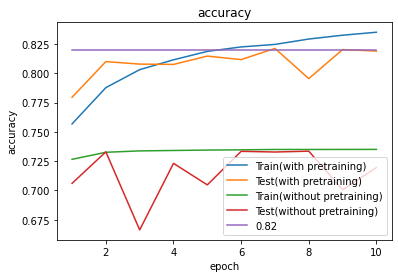

END


In [3]:


if __name__ == '__main__':
    #clear
    torch.cuda.empty_cache()
    choose = 1
    models = ["resnet18", "resnet50"] # ResNet
    
    pretrainarr = [1,0] 
    version = '7'

    batch_size = 8
    lr = 0.001
    epochs = 10
    data_path = "./data/"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = Data.DataLoader(dataloader.RetinopathyLoader(data_path, mode = 'train'),batch_size = batch_size, shuffle = True)
    test_loader = Data.DataLoader(dataloader.RetinopathyLoader(data_path, mode = 'test'), batch_size = batch_size, shuffle = True)
    classes = np.array([0, 1, 2, 3, 4])
    accuracy = []
    line_num = 0
    # start train with/without pretrain
    for pretrain in pretrainarr:
        use_model = models[choose]
        tmpstr = '(with pretraining)' if pretrain else '(without pretraining)'
        print(f'model: {use_model} {tmpstr}, learning rate: {lr}, Batch size: {batch_size}, epochs: {epochs}\n')
            
        # resnet18/resnet50 model
        if use_model == "resnet18":
            model = torchvision.models.resnet18(pretrained = pretrain)
        elif use_model == "resnet50":
            model = torchvision.models.resnet50(pretrained = pretrain)

        fc_features = model.fc.in_features
        model.fc = nn.Linear(fc_features, 5)  # change output layer to the classes
        model.to(device)

        Loss = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = 5e-4)
        accuracy.append({'epoch': [], 'accuracy': [], 'name': "Train" + tmpstr})
        accuracy.append({'epoch': [], 'accuracy': [], 'name': "Test" + tmpstr})


        max_test_acc = 0
        #start training
        for epoch in range(1,epochs+1):

            train_label = []
            train_predict = []
            #train
            model.train()
            for batch,(data, label) in enumerate(train_loader, 1):   
                data, label = data.to(device), label.to(device)

                optimizer.zero_grad()
                output = model(data)
                predict = nn.functional.softmax(output[0], dim=0)
                

                for e in output.data.max(1)[1]:
                    train_predict.append(e.item())
                for e in label:
                    train_label.append(e.item())

                loss = Loss(output, label)

                loss.backward()
                optimizer.step()

                if batch %1000 == 0:
                    print(f'now batch: {batch}')


            train_acc = accuracy_score(train_label, train_predict)
            accuracy[line_num]['epoch'].append(epoch)
            accuracy[line_num]['accuracy'].append(train_acc)

            #test
            model.eval()
            print('test')
            test_label = []
            test_predict = []
            with torch.no_grad():

                for (data, label) in test_loader:   
                    data, label = data.to(device), label.to(device)

                    output = model(data)
                    predict = nn.functional.softmax(output[0], dim=0)

                    for e in output.data.max(1)[1]:
                        test_predict.append(e.item())
                    for e in label:
                        test_label.append(e.item())

            test_acc = accuracy_score(test_label, test_predict)
            plot_confusion_matrix(test_label, test_predict, labels=classes, normalize = None, cmap = plt.cm.Blues, title = use_model + ' ' + tmpstr, epoch = epoch)
            accuracy[line_num+1]['epoch'].append(epoch)
            accuracy[line_num+1]['accuracy'].append(test_acc)
            if(max_test_acc<test_acc):
                torch.save(model, './save_model/best_'+ use_model+'_'+tmpstr  + '_' + version )
            max_test_acc = max(max_test_acc, test_acc)
           
            print(f'\nepoch: {epoch}\ntest accuracy: {test_acc}')

            if epoch %2 == 0:
                torch.save(model, './'+use_model+'_model/'+ use_model +' ' + tmpstr + '_' + str(epoch) + '_' + version )
            torch.save(model.state_dict(), './save_model/'+ use_model +' ' + tmpstr + '_' + str(epoch) + '_weight' + version)

        line_num += 2
        print(f'Best accuracy: {max_test_acc}')



    draw_curve(accuracy, use_model, "accuracy")
    print("END")




